In [1]:
import os, time, datetime, sys
import numpy as np
import pandas as pd
from collections import Counter
from functools import reduce
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_curve, auc, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib
import random

# Matplotlib中设置字体-黑体，解决Matplotlib中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决Matplotlib坐标轴负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# 读取数据
userinfo_train = pd.read_csv('./20211115_chap4/userinfo.csv')
bank_train = pd.read_csv('./20211115_chap4/bank.csv')
bill_train = pd.read_csv('./20211115_chap4/bill.csv')
overdue_train = pd.read_csv('./20211115_chap4/overdue.csv')

df_list = [userinfo_train, bank_train, bill_train, overdue_train]

In [3]:
for _df in df_list:
    print(_df.shape)

(10000, 6)
(1068424, 12)
(429441, 22)
(10000, 3)


In [4]:
userinfo_train.head(5)

,new_user_id,性别,职业,教育程度,婚姻状态,户口类型
0,7259fe272934e0dc348092c37544a445,女,公职,本科及以上,未婚,集体户口
1,0c87f6b1f7e0350a35841ba34df9d26a,男,公职,本科及以上,离异,集体户口
2,74c53a62f15cc039864aefc41170f81b,男,公职,大专,离异,家庭户口
3,211f56f356fa6ecc6334bb73e52c7b16,男,企业,高中,离异,农业户口
4,07b0d9ac7924424894141b2fecfa0ee0,男,公职,本科及以上,已婚,集体户口


In [5]:
bank_train.head(5)

,new_user_id,交易时间戳,交易类型,交易金额,工资收入标记,交易时间,交易年,交易月,交易日,交易时,交易分,交易秒
0,65b01fba105ee82613babff7c88929c5,58848407247,1,43.757548,0,2156-06-25 21:58:44,2156,6,25,21,58,44
1,65b01fba105ee82613babff7c88929c5,58849365297,1,42.143743,0,2156-06-27 00:35:29,2156,6,27,0,35,29
2,65b01fba105ee82613babff7c88929c5,58850118237,1,40.189051,0,2156-06-27 21:30:23,2156,6,27,21,30,23
3,65b01fba105ee82613babff7c88929c5,58850118447,1,40.189051,0,2156-06-27 21:30:44,2156,6,27,21,30,44
4,65b01fba105ee82613babff7c88929c5,58850244487,1,40.189051,0,2156-06-28 01:00:48,2156,6,28,1,0,48


In [6]:
bill_train.head(5)

,new_user_id,账单时间戳,银行id,上期账单金额,上期还款金额,信用卡额度,本期账单余额,本期账单最低还款额,消费笔数,本期账单金额,...,可用金额,预借现金额度,还款状态,账单时间,账单年,账单月,账单日,账单时,账单分,账单秒
0,eddcaa8984f8db5199ec28323efb18a4,59067443637,6,50.622246,50.657612,52.596975,50.897707,49.846899,1,26.457513,...,26.457513,51.933872,0,2157-03-06 10:19:23,2157,3,6,10,19,23
1,eddcaa8984f8db5199ec28323efb18a4,59067444017,6,50.897707,50.901821,52.596975,51.101179,49.911428,1,26.457513,...,26.457513,51.933872,0,2157-03-06 10:20:01,2157,3,6,10,20,1
2,eddcaa8984f8db5199ec28323efb18a4,59067444277,6,51.101179,51.137354,52.596975,51.283715,49.977605,1,26.457513,...,26.457513,51.933872,0,2157-03-06 10:20:27,2157,3,6,10,20,27
3,eddcaa8984f8db5199ec28323efb18a4,59067445157,6,51.283715,51.283799,52.915867,52.252502,50.474921,1,26.457513,...,26.457513,52.256811,0,2157-03-06 10:21:55,2157,3,6,10,21,55
4,eddcaa8984f8db5199ec28323efb18a4,59067445627,6,52.252502,52.256812,52.915867,52.304048,50.508400,1,26.457513,...,26.457513,52.256811,0,2157-03-06 10:22:42,2157,3,6,10,22,42


In [7]:
overdue_train.head(5)

,new_user_id,标签,分数
0,eddcaa8984f8db5199ec28323efb18a4,0,80.619639
1,65b01fba105ee82613babff7c88929c5,1,53.052357
2,968083a2d1a7e6b5b85a66b0bc412830,1,46.796518
3,18aeed58fd39a58cc1430a3a417ed7a9,1,82.354501
4,bae4896cea4a34616ae3babca11439ae,1,83.758928


## 检查空值

In [8]:
for df in df_list:
    print(np.any(df.isnull()))

True
False
False
False


`userinfo_train` 里存在空值，看一下空值多不多。

In [9]:
if np.any(userinfo_train.isnull()):
    print("存在空值")
else:
    print("不存在空值")
# 各列有多少空值
print(userinfo_train.isnull().sum(axis=0))
# 顶多有 null_number 行是空值
null_number = sum(userinfo_train.isnull().sum(axis=0))
# 把所有空值的行显示出来
print(userinfo_train[userinfo_train.isnull().T.any()].head(null_number))

存在空值
new_user_id    0
性别             0
职业             2
教育程度           0
婚姻状态           1
户口类型           0
dtype: int64
                           new_user_id 性别   职业   教育程度 婚姻状态  户口类型
31    3be79a55ccf09062cdff1b9c684179f9  男  NaN  本科及以上   离异  农业户口
135   b074add6f740af33df4230f28d37a333  男  NaN     大专   离异  家庭户口
5345  9f2e0eb314d821f8d075fbc9e64ce4f5  男   公职     高中  NaN  农业户口


只有 `3` 行，因此我们仅仅删除这几行数据就好。

In [10]:
userinfo_train = userinfo_train[~userinfo_train.isnull().T.any()]

In [11]:
userinfo_train.shape

(9997, 6)

## 数据编码

In [12]:
def toDict(col):
    """
    这个函数的作用：生成替换字典，加入 col 列有两种值 A B
    则生成：{A: 0, B: 1}  即把 A 替换为 0 ， B 替换为 1
    """
    res = {}
    cnt = 0
    for e in userinfo_train[col].unique():
        res[e] = cnt
        cnt += 1
    return res
# 生成列的替换字典
dict1 = toDict("性别")
dict2 = toDict("职业")
dict3 = toDict("教育程度")
dict4 = toDict("婚姻状态")
dict5 = toDict("户口类型")
# 替换后结果
userinfo_train = userinfo_train.replace({"性别": dict1, "职业": dict2, "教育程度": dict3, "婚姻状态": dict4, "户口类型": dict5})

In [13]:
userinfo_train.head(5)

,new_user_id,性别,职业,教育程度,婚姻状态,户口类型
0,7259fe272934e0dc348092c37544a445,0,0,0,0,0
1,0c87f6b1f7e0350a35841ba34df9d26a,1,0,0,1,0
2,74c53a62f15cc039864aefc41170f81b,1,0,1,1,1
3,211f56f356fa6ecc6334bb73e52c7b16,1,1,2,1,2
4,07b0d9ac7924424894141b2fecfa0ee0,1,0,0,2,0


再试一试独热编码。

In [14]:
new_userinfo_train = pd.get_dummies(userinfo_train, columns=["性别", "职业", "教育程度", "婚姻状态", "户口类型"])

In [15]:
new_userinfo_train.head(5)  # 为了保证后面的代码清晰，我们先不用独热编码（独热编码列名太多），这里仅仅展示

,new_user_id,性别_0,性别_1,性别_2,职业_0,职业_1,职业_2,职业_3,职业_4,教育程度_0,...,婚姻状态_1,婚姻状态_2,婚姻状态_3,婚姻状态_4,婚姻状态_5,户口类型_0,户口类型_1,户口类型_2,户口类型_3,户口类型_4
0,7259fe272934e0dc348092c37544a445,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0c87f6b1f7e0350a35841ba34df9d26a,0,1,0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,74c53a62f15cc039864aefc41170f81b,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,211f56f356fa6ecc6334bb73e52c7b16,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,07b0d9ac7924424894141b2fecfa0ee0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


## 单变量预测的效果？

In [16]:
# 定义总表
df = pd.merge(userinfo_train, overdue_train, on='new_user_id', how='left')

feats = ['职业']
X_train, X_test, Y_train, Y_test = train_test_split(df[feats], df[['分数']], test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'对“分数”列做回归任务，特征数量为 1 个， 均方差:{mse :.4f}')

对“分数”列做回归任务，特征数量为 1 个， 均方差:186.5847


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


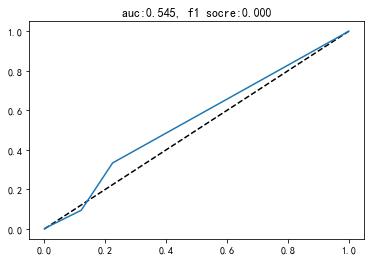

In [17]:
feats = ['职业']
X_train, X_test, Y_train, Y_test = train_test_split(df[feats], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]  # 各个测试样本 softmax ，用于计算 roc
Y_pred_lab = model.predict(X_test)  # 各个测试样本预测出的标签
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'auc:{roc_auc :.3f}, f1 socre:{f1_score(Y_test, Y_pred_lab) :.3f}')
plt.show()

## 特征工程：第一阶段

```python
feat_1 = ['职业', '教育程度', '婚姻状态', '平均欠款金额', '平均工资收入']
```

In [18]:
bill_train["欠款金额"] = bill_train["上期账单金额"] - bill_train["上期还款金额"]
agg_cormoney = bill_train.groupby("new_user_id")["欠款金额"].agg(["mean"])
agg_cormoney.columns = ["平均欠款金额"]
agg_cormoney.reset_index(inplace=True)
agg_cormoney.head(5)

,new_user_id,平均欠款金额
0,0000a11bede26d01990cd7bf86a4ffed,1.595222
1,0001102f53f24a8952ed5b47f9564354,-1.647174
2,000228d848615f1320914e0cf6064d12,-24.352021
3,0003f283dfacd7100bba76d876cf94da,-3.289508
4,000fc975cf7a868719446414a5034eae,0.702195


In [19]:
agg_salary1 = bank_train[bank_train['工资收入标记'] == 1].groupby("new_user_id")['交易金额'].agg(["mean"])
agg_salary1.columns = ['平均工资收入']
agg_salary1.reset_index(inplace=True)
agg_salary1.head(5)

,new_user_id,平均工资收入
0,00375b8a7a62da4f578f4f4464fc4228,44.964550
1,00872649357929f1f3d7fafbe484810b,46.415984
2,00e44c200eeb161df7d08ac1b79bd4a7,47.292812
3,02419b54629f540d3430e6ba8230aac4,45.600048
4,024c12c231362aa4206c001674abe30f,40.380961


In [20]:
# 第一阶段用到的特征
feat_1 = ['职业', '教育程度', '婚姻状态', '平均欠款金额', '平均工资收入']

df = pd.merge(df, agg_cormoney, on='new_user_id', how='left')
df = pd.merge(df, agg_salary1, on='new_user_id', how='left')
df = df.fillna(0)  # 填补空值

### 看看效果

In [21]:
feats = feat_1
X_train, X_test, Y_train, Y_test = train_test_split(df[feats], df[['分数']], test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'对“分数”列做回归任务，特征数量为 {len(feats)} 个， 均方差:{mse :.4f}')

对“分数”列做回归任务，特征数量为 5 个， 均方差:102.3187


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


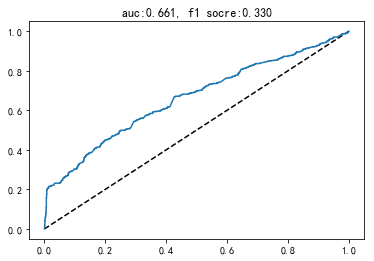

In [22]:
feats = feat_1
X_train, X_test, Y_train, Y_test = train_test_split(df[feats], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]  # 各个测试样本 softmax ，用于计算 roc
Y_pred_lab = model.predict(X_test)  # 各个测试样本预测出的标签
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'auc:{roc_auc :.3f}, f1 socre:{f1_score(Y_test, Y_pred_lab) :.3f}')
plt.show()

## 特征工程：第二阶段

```python
feat_2 = ["过去半年内工资增长趋势", "过去半年内收入波动", "平均还款比例"]
```

In [23]:
bill_train["还款比例"] = bill_train["上期账单金额"] / bill_train["上期还款金额"]
agg_cormoney = bill_train.groupby("new_user_id")["还款比例"].agg(["mean"])
agg_cormoney.columns = ["平均还款比例"]
agg_cormoney.reset_index(inplace=True)
agg_cormoney.head(5)

,new_user_id,平均还款比例
0,0000a11bede26d01990cd7bf86a4ffed,1.032223
1,0001102f53f24a8952ed5b47f9564354,0.968705
2,000228d848615f1320914e0cf6064d12,0.520719
3,0003f283dfacd7100bba76d876cf94da,0.926490
4,000fc975cf7a868719446414a5034eae,1.014207


In [24]:
def cust_period(value, op="days", op_period=0, base_dt=None):
    value_list = value.tolist()
    
    while "-1" in value_list:
        value_list.remove("-1")
    if len(value_list) != 0:
        if not base_dt:
            max_dt = max(value_list)
        else:
            max_dt = base_dt

        if op == "years":
            end_dt = (datetime.datetime.strptime(max_dt, "%Y-%m-%d %H:%M:%S") + relativedelta(years=-op_period)).strftime("%Y-%m-%d %H:%M:%S")
        elif op == "months":
            end_dt = (datetime.datetime.strptime(max_dt, "%Y-%m-%d %H:%M:%S") + relativedelta(months=-op_period)).strftime("%Y-%m-%d %H:%M:%S")
        elif op == "weeks":
            end_dt = (datetime.datetime.strptime(max_dt, "%Y-%m-%d %H:%M:%S") + relativedelta(weeks=-op_period)).strftime("%Y-%m-%d %H:%M:%S")
        elif op == "days":
            end_dt = (datetime.datetime.strptime(max_dt, "%Y-%m-%d %H:%M:%S") + relativedelta(days=-op_period)).strftime("%Y-%m-%d %H:%M:%S")
        else:
            print("Wrong operation unit of time!")
            exit()
        period = list(value.values >= end_dt)
        return period
    else:
        return [True]*len(value.tolist())


# 过去半年内工资增长趋势
agg_agg_6m = bank_train[bank_train['工资收入标记'] == 1].groupby("new_user_id")["交易金额","交易时间"]
def func(x):  # 和 apply 联合使用取出最近6个月的数据
    idxs = cust_period(x["交易时间"], "months", 6)
    return x[idxs]
agg_agg_6m = agg_agg_6m.apply(func)
agg_agg_6m = agg_agg_6m.groupby("new_user_id")["交易金额"].agg(["sum"])
agg_agg_6m.columns = ["6月内工资收入"]
agg_agg_6m.reset_index(inplace=True)
agg_agg_3m = bank_train[bank_train['工资收入标记'] == 1].groupby("new_user_id")["交易金额","交易时间"]
def func(x):  # 和 apply 联合使用取出最近3个月的数据
    idxs = cust_period(x["交易时间"], "months", 3)
    return x[idxs]
agg_agg_3m = agg_agg_3m.apply(func)
agg_agg_3m = agg_agg_3m.groupby("new_user_id")["交易金额"].agg(["sum"])
agg_agg_3m.columns = ["3月内工资收入"]
agg_agg_3m.reset_index(inplace=True)
agg_tend_3m = pd.merge(agg_agg_6m, agg_agg_3m, how='left', on=['new_user_id'])
agg_tend_3m["半年到3月前工资收入"] = agg_tend_3m["6月内工资收入"] - agg_tend_3m['3月内工资收入']
def cal(x):
    if x['3月内工资收入'] >= x['半年到3月前工资收入']:
        return 1
    return 0
agg_tend_3m["过去半年内工资增长趋势"] = agg_tend_3m.apply(cal, axis=1)


# 过去半年内收入波动
# 交易类型是 0 的为收入，1 是支出
in_train = bank_train[bank_train['交易类型'] == 1]
# 以月为单位统计标准差
agg_agg_tot = in_train.groupby("new_user_id")[['new_user_id']].agg('count')
agg_agg_tot.columns = ['None']
agg_agg_tot.reset_index(inplace=True)
agg_agg_tot = agg_agg_tot[['new_user_id']]
for i in range(1, 7):
    agg_agg_ins = in_train.groupby("new_user_id")["交易金额","交易时间"]
    def func(x):  # 和 apply 联合使用取出最近i个月的数据
        idxs = cust_period(x["交易时间"], "months", i)
        return x[idxs]
    agg_agg_ins = agg_agg_ins.apply(func)
    agg_agg_ins = agg_agg_ins.groupby("new_user_id")["交易金额"].agg(["sum"])
    agg_agg_ins.columns = [f"{i}月内收入"]
    agg_agg_ins.reset_index(inplace=True)
    agg_agg_tot = pd.merge(agg_agg_tot, agg_agg_ins, how='left', on=['new_user_id'])
for i in range(2, 7):
    agg_agg_tot[f'{i-1}到{i}月收入'] = agg_agg_tot[f"{i}月内收入"] - agg_agg_tot[f"{i-1}月内收入"]
agg_agg_tot[f'{0}到{1}月收入'] = agg_agg_tot[f"{1}月内收入"]
cols = [f'{i-1}到{i}月收入' for i in range(1, 7)]
def func(x):  # 和 apply 联用计算各个月收入标准差
    tmp = []
    for c in cols:  # cols 是['1到2月收入', '2到3月收入', '3到4月收入', ...]
        tmp.append(x[c])
    return np.std(tmp)  # 这里 apply 中 axis=1 ，x 是每一行数据， apply 分别对每一行执行 func
agg_agg_tot['过去半年内收入波动'] = agg_agg_tot.apply(func, axis=1)

In [25]:
agg_tend_3m.head(10)

,new_user_id,6月内工资收入,3月内工资收入,半年到3月前工资收入,过去半年内工资增长趋势
0,00375b8a7a62da4f578f4f4464fc4228,179.858202,179.858202,0.000000,1
1,00872649357929f1f3d7fafbe484810b,232.079920,232.079920,0.000000,1
2,00e44c200eeb161df7d08ac1b79bd4a7,47.292812,47.292812,0.000000,1
3,02419b54629f540d3430e6ba8230aac4,723.807150,505.340387,218.466763,1
4,024c12c231362aa4206c001674abe30f,444.190576,240.997538,203.193037,1
5,0283fd1f4cc29ecccb91393bc8938e1c,371.598070,232.855828,138.742242,1
6,029adc5d08f3948df629055485aeceb0,325.453135,185.783126,139.670009,1
7,0308e51ca45954096c940b9f6c79b649,45.972927,45.972927,0.000000,1
8,031d455bd7a7cb53e924c1378319a989,326.879609,140.095452,186.784157,0
9,03527bc0cb94b4cd2c75d1206e948269,128.677487,128.677487,0.000000,1


In [26]:
agg_agg_tot.head(5)

,new_user_id,1月内收入,2月内收入,3月内收入,4月内收入,5月内收入,6月内收入,1到2月收入,2到3月收入,3到4月收入,4到5月收入,5到6月收入,0到1月收入,过去半年内收入波动
0,0003f283dfacd7100bba76d876cf94da,1370.029320,2077.131122,2409.089923,3188.894728,4111.918439,4570.785390,707.101802,331.958801,779.804805,923.023711,458.866951,1370.029320,335.604913
1,00284cf15ae27d1ddf4f93922cd7bcb5,12325.866287,23200.344244,40680.862121,60546.818365,60546.818365,60546.818365,10874.477957,17480.517877,19865.956244,0.000000,0.000000,12325.866287,7739.721904
2,00375b8a7a62da4f578f4f4464fc4228,6791.505674,9954.923321,9954.923321,10772.738636,10772.738636,11216.671980,3163.417647,0.000000,817.815315,0.000000,443.933344,6791.505674,2450.466084
3,0057bbe021e9c3fc79834e3ff126bb98,1131.440292,1836.303262,3327.108790,5238.269238,6419.212381,7321.210754,704.862970,1490.805528,1911.160448,1180.943143,901.998373,1131.440292,393.043172
4,00872649357929f1f3d7fafbe484810b,664.916185,1321.637488,1536.418315,1619.892389,1917.798447,1958.840734,656.721302,214.780827,83.474075,297.906057,41.042287,664.916185,250.804742


In [27]:
# 第二阶段用到的特征
feat_2 = ["过去半年内工资增长趋势", "过去半年内收入波动", "平均还款比例"]

# 定义总表
df = pd.merge(df, agg_cormoney, on='new_user_id', how='left')
df = pd.merge(df, agg_tend_3m[['new_user_id', '过去半年内工资增长趋势']], on='new_user_id', how='left')
df = pd.merge(df, agg_agg_tot[['new_user_id', '过去半年内收入波动']], on='new_user_id', how='left')
df = df.fillna(0)  # 填补空值

### 看看效果

In [28]:
feats = feat_1 + feat_2
X_train, X_test, Y_train, Y_test = train_test_split(df[feats], df[['分数']], test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'对“分数”列做回归任务，特征数量为 {len(feats)} 个， 均方差:{mse :.4f}')

对“分数”列做回归任务，特征数量为 8 个， 均方差:71.1639


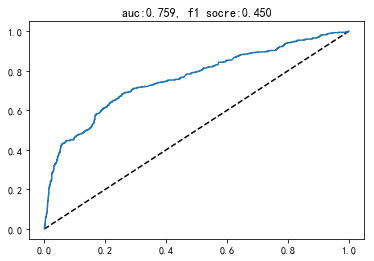

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(df[feats], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]  # 各个测试样本 softmax ，用于计算 roc
Y_pred_lab = model.predict(X_test)  # 各个测试样本预测出的标签
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'auc:{roc_auc :.3f}, f1 socre:{f1_score(Y_test, Y_pred_lab) :.3f}')
plt.show()

## 特征工程：第三阶段

```python
feat_3 = ['平均本期还款总额', '平均信用卡使用额度', '平均本期账单余额比信用卡额度',
    '最大工资收入', '最小工资收入', '最大非工资收入', '最小非工资收入',
       '60天内工资收入_sum', '最近30天内工资收入_sum', '上个30天内工资收入_sum', '工资收入变化趋势',
       '60天内非工资收入_sum', '最近30天内非工资收入_sum', '上个30天内非工资收入_sum', '非工资收入变化趋势',
       '最近3天交易金额', '最近30天交易金额', '最近2月交易金额', '交易类型_0_交易金额_max',
       '交易类型_0_交易金额_min', '交易类型_0_交易金额_mean', '交易类型_0_交易金额_count',
       '交易类型_0_交易金额_sum', '交易类型_1_交易金额_max', '交易类型_1_交易金额_min',
       '交易类型_1_交易金额_mean', '交易类型_1_交易金额_count', '交易类型_1_交易金额_sum'
]
```

In [30]:
bill_train[['new_user_id', '上期账单金额', '上期还款金额', '本期账单金额', '调整金额', '循环利息', '信用卡额度', '可用金额', '本期账单余额']].head(5)

,new_user_id,上期账单金额,上期还款金额,本期账单金额,调整金额,循环利息,信用卡额度,可用金额,本期账单余额
0,eddcaa8984f8db5199ec28323efb18a4,50.622246,50.657612,26.457513,26.457513,26.457513,52.596975,26.457513,50.897707
1,eddcaa8984f8db5199ec28323efb18a4,50.897707,50.901821,26.457513,26.457513,26.457513,52.596975,26.457513,51.101179
2,eddcaa8984f8db5199ec28323efb18a4,51.101179,51.137354,26.457513,26.457513,26.457513,52.596975,26.457513,51.283715
3,eddcaa8984f8db5199ec28323efb18a4,51.283715,51.283799,26.457513,26.457513,26.457513,52.915867,26.457513,52.252502
4,eddcaa8984f8db5199ec28323efb18a4,52.252502,52.256812,26.457513,26.457513,26.457513,52.915867,26.457513,52.304048


In [31]:
def make_feats_for_bills(data):
    data["本期还款总额"] = data["上期账单金额"] - data["上期还款金额"] + data["本期账单金额"] - data["调整金额"] + data["循环利息"]
    data["信用卡使用额度"] = data["信用卡额度"] - data["可用金额"]
    data["本期账单余额比信用卡额度"] = data["本期账单余额"] / data["信用卡额度"]
    return data
bill_train = make_feats_for_bills(bill_train)
cormoeny_cols = ['本期还款总额', '信用卡使用额度', '本期账单余额比信用卡额度']
agg_cormoney = bill_train.groupby("new_user_id")[cormoeny_cols].agg(["mean"])
agg_cormoney.columns = ['平均本期还款总额', '平均信用卡使用额度', '平均本期账单余额比信用卡额度']
agg_cormoney.reset_index(inplace=True)
agg_cormoney.head(5)

,new_user_id,平均本期还款总额,平均信用卡使用额度,平均本期账单余额比信用卡额度
0,0000a11bede26d01990cd7bf86a4ffed,58.992290,25.229282,0.999978
1,0001102f53f24a8952ed5b47f9564354,26.549467,25.400320,0.833627
2,000228d848615f1320914e0cf6064d12,46.899987,24.982204,0.997087
3,0003f283dfacd7100bba76d876cf94da,42.336529,19.557016,0.994457
4,000fc975cf7a868719446414a5034eae,51.901119,23.668352,1.097286


In [32]:
agg_salary1_max = bank_train[bank_train['工资收入标记'] == 1].groupby("new_user_id")['交易金额'].agg(["max"])
agg_salary1_max.columns = ['最大工资收入']
agg_salary1_max.reset_index(inplace=True)
agg_salary1_min = bank_train[bank_train['工资收入标记'] == 1].groupby("new_user_id")['交易金额'].agg(["min"])
agg_salary1_min.columns = ['最小工资收入']
agg_salary1_min.reset_index(inplace=True)
agg_salary0_max = bank_train[bank_train['工资收入标记'] == 0].groupby("new_user_id")['交易金额'].agg(["max"])
agg_salary0_max.columns = ['最大非工资收入']
agg_salary0_max.reset_index(inplace=True)
agg_salary0_min = bank_train[bank_train['工资收入标记'] == 0].groupby("new_user_id")['交易金额'].agg(["min"])
agg_salary0_min.columns = ['最小非工资收入']
agg_salary0_min.reset_index(inplace=True)

In [33]:
# 工资收入变化趋势
def func(x):  # 和 apply 联合使用取出最近60天的数据
    idxs = cust_period(x["交易时间"], "days", 60)
    return x[idxs]
agg_agg_1_00_60 = bank_train[bank_train['工资收入标记'] == 1].groupby("new_user_id")["交易金额","交易时间"].apply(func)
agg_agg_1_00_60 = agg_agg_1_00_60.groupby("new_user_id")["交易金额"].agg(["sum"])
agg_agg_1_00_60.columns = "60天内工资收入_" + agg_agg_1_00_60.columns
agg_agg_1_00_60.reset_index(inplace=True)
def func(x):  # 和 apply 联合使用取出最近30天的数据
    idxs = cust_period(x["交易时间"], "days", 30)
    return x[idxs]
agg_agg_1_30_60 = bank_train[bank_train['工资收入标记'] == 1].groupby("new_user_id")["交易金额","交易时间"].apply(func)
agg_agg_1_30_60 = agg_agg_1_30_60.groupby("new_user_id")["交易金额"].agg(["sum"])
agg_agg_1_30_60.columns = "最近30天内工资收入_" + agg_agg_1_30_60.columns
agg_agg_1_30_60.reset_index(inplace=True)
agg_agg_tend1 = pd.merge(agg_agg_1_00_60, agg_agg_1_30_60, how='left', on=['new_user_id'])
agg_agg_tend1["上个30天内工资收入_sum"] = agg_agg_tend1["60天内工资收入_sum"] - agg_agg_tend1['最近30天内工资收入_sum']
def calc(x):
    if x['最近30天内工资收入_sum'] >= x['上个30天内工资收入_sum']:
        return 1
    return 0
agg_agg_tend1["工资收入变化趋势"] = agg_agg_tend1.apply(calc, axis=1)
# 非工资收入变化趋势
def func(x):  # 和 apply 联合使用取出最近60天的数据
    idxs = cust_period(x["交易时间"], "days", 60)
    return x[idxs]
agg_agg_2_00_60 = bank_train[bank_train['工资收入标记'] == 0].groupby("new_user_id")["交易金额","交易时间"].apply(func)
agg_agg_2_00_60 = agg_agg_2_00_60.groupby("new_user_id")["交易金额"].agg(["sum"])
agg_agg_2_00_60.columns = "60天内非工资收入_" + agg_agg_2_00_60.columns
agg_agg_2_00_60.reset_index(inplace=True)
def func(x):  # 和 apply 联合使用取出最近30天的数据
    idxs = cust_period(x["交易时间"], "days", 30)
    return x[idxs]
agg_agg_2_30_60 = bank_train[bank_train['工资收入标记'] == 0].groupby("new_user_id")["交易金额","交易时间"].apply(func)
agg_agg_2_30_60 = agg_agg_2_30_60.groupby("new_user_id")["交易金额"].agg(["sum"])
agg_agg_2_30_60.columns = "最近30天内非工资收入_" + agg_agg_2_30_60.columns
agg_agg_2_30_60.reset_index(inplace=True)
agg_agg_tend2 = pd.merge(agg_agg_2_00_60, agg_agg_2_30_60, how='left', on=['new_user_id'])
agg_agg_tend2["上个30天内非工资收入_sum"] = agg_agg_tend2["60天内非工资收入_sum"] - agg_agg_tend2['最近30天内非工资收入_sum']
def calc(x):
    if x['最近30天内非工资收入_sum'] >= x['上个30天内非工资收入_sum']:
        return 1
    return 0
agg_agg_tend2["非工资收入变化趋势"] = agg_agg_tend2.apply(calc, axis=1)

In [34]:
agg_agg_tend1.head(5)

,new_user_id,60天内工资收入_sum,最近30天内工资收入_sum,上个30天内工资收入_sum,工资收入变化趋势
0,00375b8a7a62da4f578f4f4464fc4228,134.438279,45.603411,88.834868,0
1,00872649357929f1f3d7fafbe484810b,185.907274,185.907274,0.000000,1
2,00e44c200eeb161df7d08ac1b79bd4a7,47.292812,47.292812,0.000000,1
3,02419b54629f540d3430e6ba8230aac4,458.439674,184.426852,274.012822,0
4,024c12c231362aa4206c001674abe30f,240.997538,201.300426,39.697112,1


In [35]:
# 最近3天交易金额
def func(x):  # 和 apply 联合使用取出最近3天的数据
    idxs = cust_period(x["交易时间"], "days", 3)
    return x[idxs]
agg_3dtrade = bank_train.groupby("new_user_id")["交易金额","交易时间"].apply(func)
agg_3dtrade = agg_3dtrade.groupby("new_user_id")["交易金额"].agg(["sum"])
agg_3dtrade.columns = ["最近3天交易金额"]
agg_3dtrade.reset_index(inplace=True)
# 最近30天交易金额
def func(x):  # 和 apply 联合使用取出最近30天的数据
    idxs = cust_period(x["交易时间"], "days", 30)
    return x[idxs]
agg_30dtrade = bank_train.groupby("new_user_id")["交易金额","交易时间"].apply(func)
agg_30dtrade = agg_30dtrade.groupby("new_user_id")["交易金额"].agg(["sum"])
agg_30dtrade.columns = ["最近30天交易金额"]
agg_30dtrade.reset_index(inplace=True)
# 最近2月交易金额
def func(x):  # 和 apply 联合使用取出最近2个月的数据
    idxs = cust_period(x["交易时间"], "months", 2)
    return x[idxs]
agg_2mtrade = bank_train.groupby("new_user_id")["交易金额","交易时间"].apply(func)
agg_2mtrade = agg_2mtrade.groupby("new_user_id")["交易金额"].agg(["sum"])
agg_2mtrade.columns = ["最近2月交易金额"]
agg_2mtrade.reset_index(inplace=True)
# 交易行为的聚类特征
agg_agg_behavior = bank_train.groupby(["new_user_id", "交易类型"])["交易金额"].agg(["max", "min", "mean", "count", "sum"])
agg_agg_behavior.reset_index(inplace=True)
agg_agg_behavior_1 = agg_agg_behavior[agg_agg_behavior['交易类型']==1][["new_user_id", "max", "min", "mean", "count", "sum"]]
agg_agg_behavior_0 = agg_agg_behavior[agg_agg_behavior['交易类型']==0][["new_user_id", "max", "min", "mean", "count", "sum"]]
agg_agg_behavior_0.columns = ["new_user_id", "交易类型_0_交易金额_max", "交易类型_0_交易金额_min", "交易类型_0_交易金额_mean", "交易类型_0_交易金额_count", "交易类型_0_交易金额_sum"]
agg_agg_behavior_1.columns = ["new_user_id", "交易类型_1_交易金额_max", "交易类型_1_交易金额_min", "交易类型_1_交易金额_mean", "交易类型_1_交易金额_count", "交易类型_1_交易金额_sum"]

In [36]:
# 定义总表
feat_3 = ['平均本期还款总额', '平均信用卡使用额度', '平均本期账单余额比信用卡额度',
    '最大工资收入', '最小工资收入', '最大非工资收入', '最小非工资收入',
       '60天内工资收入_sum', '最近30天内工资收入_sum', '上个30天内工资收入_sum', '工资收入变化趋势',
       '60天内非工资收入_sum', '最近30天内非工资收入_sum', '上个30天内非工资收入_sum', '非工资收入变化趋势',
       '最近3天交易金额', '最近30天交易金额', '最近2月交易金额', '交易类型_0_交易金额_max',
       '交易类型_0_交易金额_min', '交易类型_0_交易金额_mean', '交易类型_0_交易金额_count',
       '交易类型_0_交易金额_sum', '交易类型_1_交易金额_max', '交易类型_1_交易金额_min',
       '交易类型_1_交易金额_mean', '交易类型_1_交易金额_count', '交易类型_1_交易金额_sum'
]

df = pd.merge(df, agg_cormoney, on='new_user_id', how='left')
df = pd.merge(df, agg_salary1_max, on='new_user_id', how='left')
df = pd.merge(df, agg_salary1_min, on='new_user_id', how='left')
df = pd.merge(df, agg_salary0_max, on='new_user_id', how='left')
df = pd.merge(df, agg_salary0_min, on='new_user_id', how='left')
df = pd.merge(df, agg_agg_tend1, on='new_user_id', how='left')
df = pd.merge(df, agg_agg_tend2, on='new_user_id', how='left')
df = pd.merge(df, agg_3dtrade, on='new_user_id', how='left')
df = pd.merge(df, agg_30dtrade, on='new_user_id', how='left')
df = pd.merge(df, agg_2mtrade, on='new_user_id', how='left')
df = pd.merge(df, agg_agg_behavior_0, on='new_user_id', how='left')
df = pd.merge(df, agg_agg_behavior_1, on='new_user_id', how='left')
df = df.fillna(0)  # 填补空值

### 看看效果

In [37]:
feats = feat_1 + feat_2 + feat_3
X_train, X_test, Y_train, Y_test = train_test_split(df[feats], df[['分数']], test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'对“分数”列做回归任务，特征数量为 {len(feats)} 个， 均方差:{mse :.4f}')

对“分数”列做回归任务，特征数量为 36 个， 均方差:15.4250


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


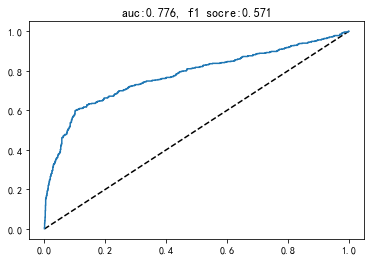

In [38]:
feats = feat_1 + feat_2 + feat_3
X_train, X_test, Y_train, Y_test = train_test_split(df[feats], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]  # 各个测试样本 softmax ，用于计算 roc
Y_pred_lab = model.predict(X_test)  # 各个测试样本预测出的标签
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'auc:{roc_auc :.3f}, f1 socre:{f1_score(Y_test, Y_pred_lab) :.3f}')
plt.show()

### 特征生成完毕后，进行特征缩放

In [39]:
df.columns

Index(['new_user_id', '性别', '职业', '教育程度', '婚姻状态', '户口类型', '标签', '分数', '平均欠款金额',
       '平均工资收入', '平均还款比例', '过去半年内工资增长趋势', '过去半年内收入波动', '平均本期还款总额', '平均信用卡使用额度',
       '平均本期账单余额比信用卡额度', '最大工资收入', '最小工资收入', '最大非工资收入', '最小非工资收入',
       '60天内工资收入_sum', '最近30天内工资收入_sum', '上个30天内工资收入_sum', '工资收入变化趋势',
       '60天内非工资收入_sum', '最近30天内非工资收入_sum', '上个30天内非工资收入_sum', '非工资收入变化趋势',
       '最近3天交易金额', '最近30天交易金额', '最近2月交易金额', '交易类型_0_交易金额_max',
       '交易类型_0_交易金额_min', '交易类型_0_交易金额_mean', '交易类型_0_交易金额_count',
       '交易类型_0_交易金额_sum', '交易类型_1_交易金额_max', '交易类型_1_交易金额_min',
       '交易类型_1_交易金额_mean', '交易类型_1_交易金额_count', '交易类型_1_交易金额_sum'],
      dtype='object')

In [40]:
def func(x):  # 和 apply 联用，对每一列进行归一化操作
    return (x - np.min(x)) / (np.max(x) - np.min(x))
X = df[feat_1 + feat_2 + feat_3].apply(func, axis=0)  # 这里 apply 中 axis=0 是对每一列进行操作
Y_regression = df[['分数']]
Y_classify = df[["标签"]]

## 进行交叉验证

### 对比一下五种配置下的结果

- 单变量
- 第一阶段特征
- 第一阶段特征 + 第二阶段特征
- 第一阶段特征 + 第二阶段特征 + 第三阶段特征
- 第一阶段特征 + 第二阶段特征 + 第三阶段特征 + 归一化

#### 首先来看回归任务表现

In [41]:
# 单变量
X_train, X_test, Y_train, Y_test = train_test_split(df[['职业']], df[['分数']], test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  单变量')

# 第一阶段特征
X_train, X_test, Y_train, Y_test = train_test_split(df[feat_1], df[['分数']], test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  第一阶段特征')

# 第一阶段特征 + 第二阶段特征
X_train, X_test, Y_train, Y_test = train_test_split(df[feat_1 + feat_2], df[['分数']], test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  第一阶段特征 + 第二阶段特征')

# 第一阶段特征 + 第二阶段特征 + 第三阶段特征
X_train, X_test, Y_train, Y_test = train_test_split(df[feat_1 + feat_2 + feat_3], df[['分数']], test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  第一阶段特征 + 第二阶段特征 + 第三阶段特征')

# 第一阶段特征 + 第二阶段特征 + 第三阶段特征 + 归一化
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  第一阶段特征 + 第二阶段特征 + 第三阶段特征 + 归一化')

均方差: 197.4535  单变量
均方差: 103.2193  第一阶段特征
均方差: 66.0625  第一阶段特征 + 第二阶段特征
均方差: 12.9046  第一阶段特征 + 第二阶段特征 + 第三阶段特征
均方差: 13.9962  第一阶段特征 + 第二阶段特征 + 第三阶段特征 + 归一化


#### 然后我们看看分类任务表现

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


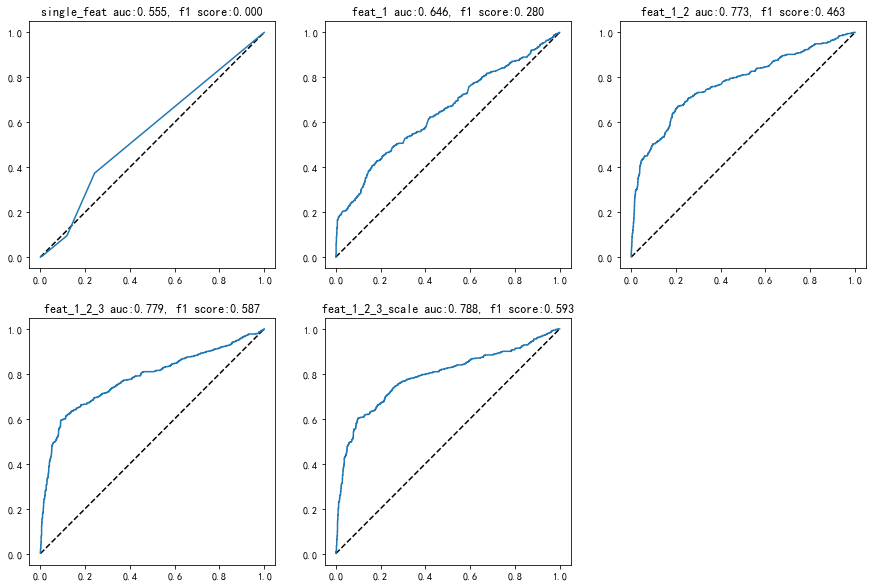

In [42]:
plt.subplots(figsize = (15,10))

# 单变量
plt.subplot(2, 3, 1)
X_train, X_test, Y_train, Y_test = train_test_split(df[['职业']], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'single_feat auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# 第一阶段特征
plt.subplot(2, 3, 2)
X_train, X_test, Y_train, Y_test = train_test_split(df[feat_1], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'feat_1 auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# 第一阶段特征 + 第二阶段特征
plt.subplot(2, 3, 3)
X_train, X_test, Y_train, Y_test = train_test_split(df[feat_1 + feat_2], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'feat_1_2 auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# 第一阶段特征 + 第二阶段特征 + 第三阶段特征
plt.subplot(2, 3, 4)
X_train, X_test, Y_train, Y_test = train_test_split(df[feat_1 + feat_2 + feat_3], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'feat_1_2_3 auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# 第一阶段特征 + 第二阶段特征 + 第三阶段特征 + 归一化
plt.subplot(2, 3, 5)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'feat_1_2_3_scale auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')
plt.show()

如上，发现效果层层递进。

### 让我们看看树模型和集成学习表现

In [43]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [44]:
# 安装 XGBoost
!pip install xgboost
from xgboost import XGBRegressor, XGBClassifier

In [45]:
# 安装 LightGBM
!pip install lightgbm==2.2.3
from lightgbm import LGBMRegressor, LGBMClassifier

#### 先看看回归任务

In [46]:
# 线性模型
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  线性模型')

# 决策树
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = DecisionTreeRegressor()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  决策树')

# 随机森林
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = RandomForestRegressor()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  随机森林')

# GBDT
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = GradientBoostingRegressor()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  GBDT')

# XGBoost
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = XGBRegressor()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  XGBoost')

# LightGBM
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = LGBMRegressor()
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred_val)
print(f'均方差: {mse :.4f}  LightGBM')

均方差: 13.0748  线性模型
均方差: 28.3219  决策树


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


均方差: 15.0490  随机森林


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


均方差: 12.7561  GBDT
均方差: 14.4983  XGBoost
均方差: 14.1290  LightGBM


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packa

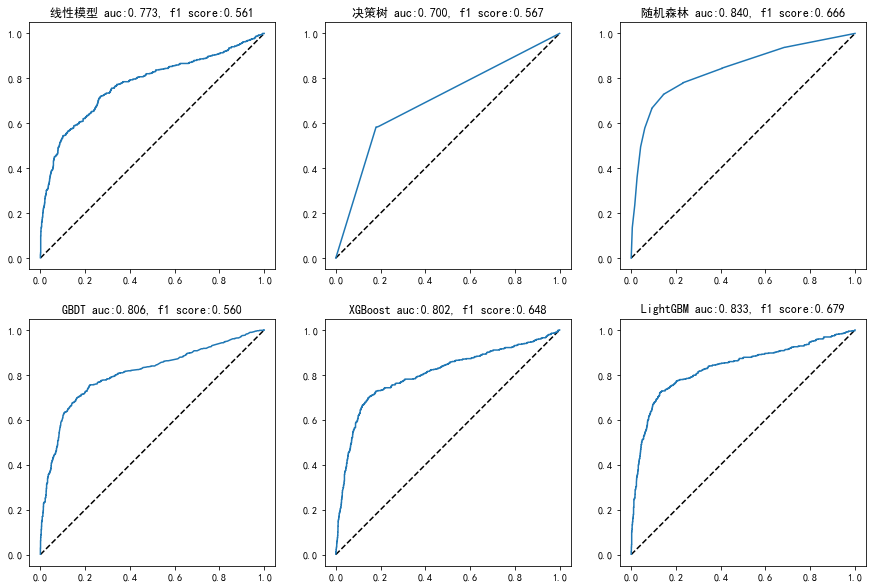

In [47]:
plt.subplots(figsize = (15,10))

# 线性模型（逻辑回归）
plt.subplot(2, 3, 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'线性模型 auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# 决策树
plt.subplot(2, 3, 2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'决策树 auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# 随机森林
plt.subplot(2, 3, 3)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = RandomForestClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'随机森林 auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# GBDT
plt.subplot(2, 3, 4)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'GBDT auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# XGBoost
plt.subplot(2, 3, 5)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = XGBClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'XGBoost auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# LightGBM
plt.subplot(2, 3, 6)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = LGBMClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'LightGBM auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')
plt.show()

### 回归任务中各个特征重要程度

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = DecisionTreeRegressor()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

 1) 交易类型_0_交易金额_mean                                             0.83558
 2) 最近30天内工资收入_sum                                               0.05776
 3) 平均本期还款总额                                                     0.02307
 4) 平均本期账单余额比信用卡额度                                               0.01817
 5) 平均还款比例                                                       0.01720
 6) 平均欠款金额                                                       0.01107
 7) 平均信用卡使用额度                                                    0.01054
 8) 职业                                                           0.00773
 9) 教育程度                                                         0.00538
10) 婚姻状态                                                         0.00313
11) 60天内工资收入_sum                                                 0.00153
12) 过去半年内收入波动                                                    0.00074
13) 过去半年内工资增长趋势                                                  0.00067
14) 最近3天交易金额                                       

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


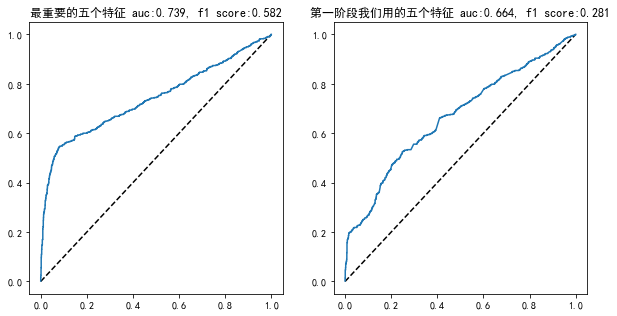

In [82]:
# 挑选最重要的 5 个特征看看和一阶段特征比较
plt.subplots(figsize = (10,5))
# 第一阶段特征
feat_new = ['交易类型_0_交易金额_mean', '最近30天内工资收入_sum', '平均本期还款总额', '平均本期账单余额比信用卡额度', '平均还款比例']
plt.subplot(1, 2, 1)
X_train, X_test, Y_train, Y_test = train_test_split(df[feat_new], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'最重要的五个特征 auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')

# 第一阶段特征
feat_1 = ['职业', '教育程度', '婚姻状态', '平均欠款金额', '平均工资收入']
plt.subplot(1, 2, 2)
X_train, X_test, Y_train, Y_test = train_test_split(df[feat_1], df[['标签']], test_size=0.2)
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_lab = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'第一阶段我们用的五个特征 auc:{roc_auc :.3f}, f1 score:{f1_score(Y_test, Y_pred_lab) :.3f}')
plt.show()

看看随机森林等模型的特征重要程度。

In [83]:
# 随机森林
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = RandomForestRegressor()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


 1) 交易类型_0_交易金额_mean                                             0.25014
 2) 交易类型_0_交易金额_count                                            0.16825
 3) 交易类型_0_交易金额_max                                              0.16707
 4) 交易类型_0_交易金额_sum                                              0.08439
 5) 交易类型_1_交易金额_mean                                             0.08427
 6) 交易类型_1_交易金额_count                                            0.08369
 7) 最近30天内工资收入_sum                                               0.03017
 8) 平均本期还款总额                                                     0.02389
 9) 平均本期账单余额比信用卡额度                                               0.01719
10) 平均还款比例                                                       0.01543
11) 60天内工资收入_sum                                                 0.01246
12) 最大工资收入                                                       0.01225
13) 平均信用卡使用额度                                                    0.01099
14) 平均欠款金额                                         

In [85]:
# GBDT
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = GradientBoostingRegressor()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 1) 平均本期账单余额比信用卡额度                                               0.13064
 2) 交易类型_0_交易金额_mean                                             0.08699
 3) 平均本期还款总额                                                     0.08192
 4) 平均欠款金额                                                       0.07658
 5) 职业                                                           0.05494
 6) 最近3天交易金额                                                     0.05443
 7) 教育程度                                                         0.05214
 8) 婚姻状态                                                         0.04449
 9) 交易类型_1_交易金额_max                                              0.04132
10) 交易类型_1_交易金额_min                                              0.03860
11) 最小非工资收入                                                      0.03564
12) 过去半年内收入波动                                                    0.03358
13) 交易类型_1_交易金额_mean                                             0.02776
14) 最大非工资收入                                        

In [86]:
# XGBoost
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = XGBRegressor()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

 1) 过去半年内收入波动                                                    0.68553
 2) 60天内工资收入_sum                                                 0.15403
 3) 交易类型_1_交易金额_max                                              0.04357
 4) 交易类型_0_交易金额_mean                                             0.03541
 5) 平均工资收入                                                       0.02889
 6) 最近30天内工资收入_sum                                               0.01290
 7) 过去半年内工资增长趋势                                                  0.00662
 8) 交易类型_1_交易金额_mean                                             0.00337
 9) 最小工资收入                                                       0.00331
10) 上个30天内工资收入_sum                                               0.00228
11) 平均本期还款总额                                                     0.00196
12) 职业                                                           0.00173
13) 交易类型_0_交易金额_max                                              0.00169
14) 平均还款比例                                         

In [87]:
# LightGBM
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_regression, test_size=0.2)
model = LGBMRegressor()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

 1) 平均本期还款总额                                                     405.00000
 2) 平均本期账单余额比信用卡额度                                               389.00000
 3) 平均欠款金额                                                       254.00000
 4) 平均还款比例                                                       251.00000
 5) 平均信用卡使用额度                                                    196.00000
 6) 职业                                                           139.00000
 7) 教育程度                                                         135.00000
 8) 最近3天交易金额                                                     97.00000
 9) 交易类型_0_交易金额_mean                                             88.00000
10) 过去半年内收入波动                                                    86.00000
11) 交易类型_1_交易金额_mean                                             80.00000
12) 婚姻状态                                                         73.00000
13) 最大非工资收入                                                      71.00000
14) 交易类型_1_交易金额_max            

**可以看出，不同模型中特征重要性不同。** 工业界用 XGBoost 衡量特征重要性比较多。

### 分类任务中各个特征重要程度

In [90]:
# 决策树
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

 1) 交易类型_0_交易金额_sum                                              0.25498
 2) 平均信用卡使用额度                                                    0.13931
 3) 平均本期账单余额比信用卡额度                                               0.12379
 4) 平均本期还款总额                                                     0.11344
 5) 平均欠款金额                                                       0.08097
 6) 平均还款比例                                                       0.07143
 7) 教育程度                                                         0.04221
 8) 职业                                                           0.04023
 9) 婚姻状态                                                         0.03214
10) 交易类型_1_交易金额_mean                                             0.01112
11) 最近3天交易金额                                                     0.00937
12) 平均工资收入                                                       0.00780
13) 交易类型_0_交易金额_mean                                             0.00678
14) 交易类型_1_交易金额_count                              

In [91]:
# 随机森林
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = RandomForestClassifier()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

 1) 平均本期账单余额比信用卡额度                                               0.12585
 2) 平均信用卡使用额度                                                    0.11062
 3) 平均欠款金额                                                       0.09772
 4) 平均本期还款总额                                                     0.09678
 5) 平均还款比例                                                       0.09345
 6) 交易类型_0_交易金额_sum                                              0.08082
 7) 职业                                                           0.06484
 8) 最大非工资收入                                                      0.05007
 9) 教育程度                                                         0.03179
10) 婚姻状态                                                         0.03058
11) 交易类型_1_交易金额_sum                                              0.02981
12) 最近2月交易金额                                                     0.02905
13) 最近30天交易金额                                                    0.02847
14) 过去半年内收入波动                                      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [92]:
# GBDT
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 1) 平均本期账单余额比信用卡额度                                               0.13159
 2) 平均信用卡使用额度                                                    0.10575
 3) 平均本期还款总额                                                     0.08921
 4) 平均还款比例                                                       0.07502
 5) 职业                                                           0.06858
 6) 平均欠款金额                                                       0.05627
 7) 交易类型_0_交易金额_max                                              0.05362
 8) 最近2月交易金额                                                     0.05038
 9) 交易类型_1_交易金额_mean                                             0.03777
10) 交易类型_0_交易金额_mean                                             0.03726
11) 最近3天交易金额                                                     0.03652
12) 教育程度                                                         0.02761
13) 60天内非工资收入_sum                                                0.02681
14) 过去半年内收入波动                                      

In [93]:
# XGBoost
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = XGBClassifier()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 1) 60天内非工资收入_sum                                                0.49269
 2) 平均工资收入                                                       0.06003
 3) 职业                                                           0.05426
 4) 交易类型_0_交易金额_max                                              0.05265
 5) 教育程度                                                         0.02411
 6) 婚姻状态                                                         0.01707
 7) 平均信用卡使用额度                                                    0.01658
 8) 最近3天交易金额                                                     0.01533
 9) 平均本期还款总额                                                     0.01323
10) 最近2月交易金额                                                     0.01306
11) 交易类型_1_交易金额_count                                            0.01297
12) 平均还款比例                                                       0.01208
13) 平均本期账单余额比信用卡额度                                               0.01174
14) 过去半年内工资增长趋势                                    

In [94]:
# LightGBM
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_classify, test_size=0.2)
model = LGBMClassifier()
model.fit(X_train, Y_train)
feat_labels = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 按照重要性排序
for f in range(len(indices)):
    print(f"{f + 1 :2d}) {feat_labels[indices[f]] :<60} {importances[indices[f]] :>.5f}")

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 1) 平均信用卡使用额度                                                    364.00000
 2) 平均本期账单余额比信用卡额度                                               345.00000
 3) 平均本期还款总额                                                     343.00000
 4) 平均还款比例                                                       245.00000
 5) 平均欠款金额                                                       239.00000
 6) 教育程度                                                         123.00000
 7) 职业                                                           98.00000
 8) 交易类型_0_交易金额_mean                                             92.00000
 9) 过去半年内收入波动                                                    91.00000
10) 婚姻状态                                                         76.00000
11) 最近3天交易金额                                                     75.00000
12) 交易类型_1_交易金额_mean                                             73.00000
13) 上个30天内非工资收入_sum                                              64.00000
14) 交易类型_1_交易金额_max             